<a href="https://colab.research.google.com/github/IzadoraSC/scrips_workshops/blob/main/Python_GEE_treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Earth Engine com API Python**: para obtenção de imagens de satélite, e aplicação para o mapeamento de queimadas.

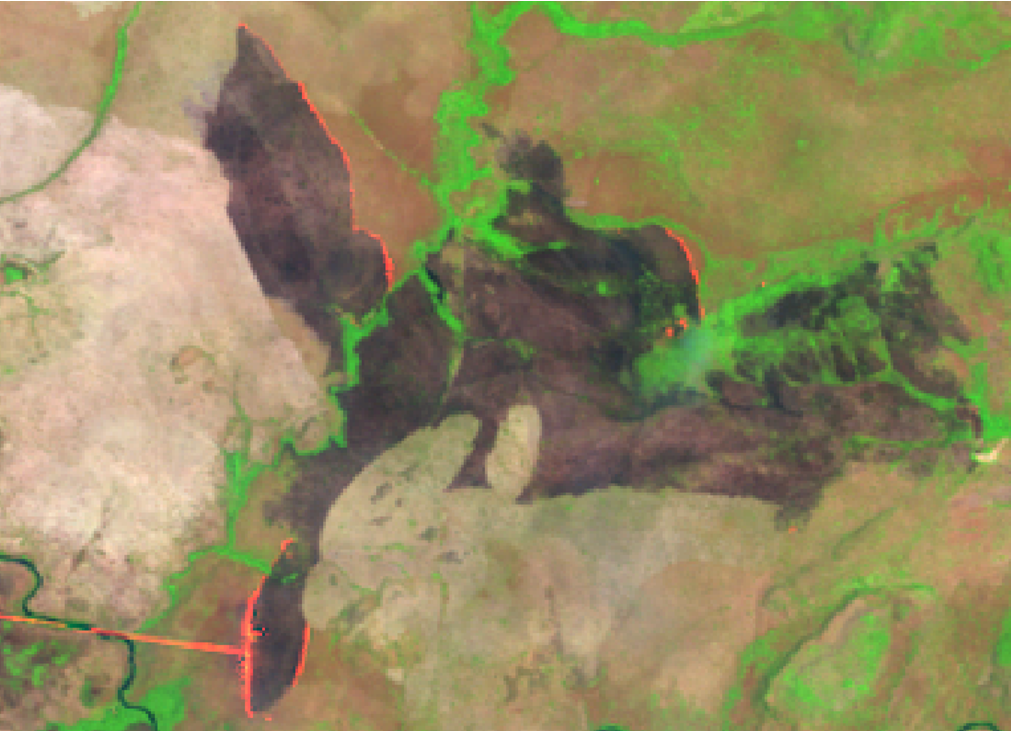

##Conectando Google Drive

In [1]:
# Conectando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ## Configurando
 - Instalando bibliotecas;
 - Autenticação;
 - Importanto bibliotecas;

### Instalando bibliotecas

In [2]:
# Instalando bibliotecas

!pip install rasterio -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.6 MB/s eta 0:00:00


In [ ]:
# Verificar bibliotecas ou pacotes instalados
!pip list

### Autenticação

In [4]:
# Autenticação e inicializando o acesso ao GEE
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-izadorasc')  ## 'project' é individual para cada usuário

### Importando bibliotecas

In [6]:
# Importar as bibliotecas
import numpy as np
import geopandas as gpd
#import geobr
import json
import os
import pandas as pd

import matplotlib.pyplot as plt

#from geobr.read_state import download_gpkg

import rasterio as rio

## Área de estudo

In [7]:
# Visualizar basemap
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [8]:
# Área de estudo
roi = ee.FeatureCollection('users/izadorasc/PNCM/limite_pncm')  #selecionar sua área de estudo
roi

In [9]:
Map = geemap.Map()
# Map.add_basemap('HYBRID')
Map.addLayer(roi, {'color':'blue'},'Parque Nacional da Chapada das Mesas')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Dados GEE

* Definir parâmentros e funções
* Selecionar coleção de imagens (Landsat)
* Exportar imagens


In [10]:
##Funções
##Máscara de nuvens
def maskL8sr(image):

    qaMask = image.select('QA_PIXEL').bitwise_and(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    ###Fator de escala
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

    return image.addBands(opticalBands, None, True)\
    .addBands(thermalBands, None, True).updateMask(qaMask)\
    .updateMask(saturationMask)

In [11]:
## Acessando dados Landsat

# Surface Reflectance
# Landsat 5 TM (Mar 16, 1984 - May 05, 2012)
  # USGS Landsat 5 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT05/C02/T1_L2"
# Landsat 8 OLI (Mar 18, 2013 - present)
  # USGS Landsat 8 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC08/C02/T1_L2"

image = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2016-01-01','2016-12-31')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER',10))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

## Verificando as bandas
bandas = image.bandNames()
bandas

In [12]:
## Composição cor verdadeira
Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],'min': 0, 'max': 0.2}, 'Image')
Map.centerObject(roi, 10)
Map

Map(bottom=68471.0, center=[-7.152470125883857, -47.144687193400344], controls=(WidgetControl(options=['positi…

In [13]:
## Composição falsa-cor

vis_params = {'bands': ['SR_B6', 'SR_B5', 'SR_B4'], 'min': 0.0, 'max': 0.4, 'opacity': 1.0, 'gamma': 0.84}

Map.addLayer(image, vis_params, 'Image')
Map.centerObject(roi,10)
Map


Map(bottom=136594.0, center=[-7.152470125883857, -47.144687193400344], controls=(WidgetControl(options=['posit…

## Pre-fire and Post-Fire

In [17]:
## Acessando dados Landsat - PRE-FIRE AND POST-FIRE

# 2016

pre_fire = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2016-04-01','2016-04-30')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER', 20))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

post_fire = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2016-05-01','2016-05-31')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER', 10))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)


In [18]:
vis_params = {'bands': ['SR_B6', 'SR_B5', 'SR_B4'], 'min': 0.0, 'max': 0.4, 'opacity': 1.0, 'gamma': 0.84}
Map = geemap.Map()
Map.addLayer(pre_fire, vis_params, 'Pre-fire')
Map.addLayer(post_fire, vis_params, 'Post-fire')
Map.centerObject(roi,10)
Map

Map(center=[-7.152470125883857, -47.144687193400344], controls=(WidgetControl(options=['position', 'transparen…

In [16]:
# Mapa comparativo - wet season and dry season

# Pre-fire and Post-fire
left_layer = geemap.ee_tile_layer(pre_fire, vis_params, 'Pre-fire')
right_layer = geemap.ee_tile_layer(post_fire, vis_params, 'Post-fire')


Map = geemap.Map(center=[-7.1,-47], zoom=10)

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [19]:

image = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2010-01-01','2010-12-31')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER',10))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

                                                 ## Verificando as bandas
bandas = image.bandNames()
bandas

In [20]:
## Acessando dados Landsat - PRE-FIRE AND POST-FIRE -

# Sem aplicação da máscara de nuvens
# 2010
pre_fire = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2010-09-01','2010-09-30')\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

post_fire = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2010-10-16','2010-10-20')\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

In [21]:
vis_paramsLS5 = {'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 'min': [3000], 'max': [20000], 'opacity': 0.85, 'gamma': 0.50}
Map = geemap.Map()
Map.addLayer(pre_fire, vis_paramsLS5, 'Pre-fire')
Map.addLayer(post_fire, vis_paramsLS5, 'Post-fire')
Map.centerObject(roi,10)
Map

Map(center=[-7.152470125883857, -47.144687193400344], controls=(WidgetControl(options=['position', 'transparen…

In [22]:
## Acessando dados Landsat - PRE-FIRE AND POST-FIRE - Com aplicação de máscara de nuvem
## 2010
pre_fire = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2010-09-01','2010-09-30')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER', 10))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

post_fire = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(roi)\
                                                 .filterDate('2010-10-16','2010-10-20')\
                                                 .filter(ee.Filter.lt('CLOUD_COVER', 10))\
                                                 .map(maskL8sr)\
                                                 .select(['SR_B.*'])\
                                                 .median().clip(roi)

In [23]:
vis_paramsLS5 = {'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 'min': [0.0], 'max': [0.6], 'opacity': 1, 'gamma':1}
Map = geemap.Map()
Map.addLayer(pre_fire, vis_paramsLS5, 'Pre-fire')
Map.addLayer(post_fire, vis_paramsLS5, 'Post-fire')
Map.centerObject(roi,10)
Map

Map(center=[-7.152470125883857, -47.144687193400344], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
# Mapa comparativo - wet season and dry season

# Pre-fire and Post-fire
left_layer = geemap.ee_tile_layer(pre_fire, vis_paramsLS5, 'Pre-fire')
right_layer = geemap.ee_tile_layer(post_fire, vis_paramsLS5, 'Post-fire')


Map = geemap.Map(center=[-7.1,-47], zoom=10)

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## Download de imagens

In [ ]:
img_clip  = image.clip(roi)
pre_fire_clip = pre_fire.clip(roi)
post_fire_clip = post_fire.clip(roi)

In [ ]:
#exportar image
task = ee.batch.Export.image.toDrive(
    image = img_clip.toFloat(),
    description = 'Landsat_2010_pncm',
    folder = 'Dados_Landsat',
    maxPixels = 1e13,
    region = roi.geometry(), # conversão necessária para recortar o raster de saída,
    scale = 30,
    crs='EPSG:4326'
)
task.start()


# task = ee.batch.Export.image.toDrive(
#     image = pre_fire_clip.toFloat(),
#     description = 'Landsat_sept_2010_pncm',
#     folder = 'Dados_Landsat',
#     maxPixels = 1e13,
#     region = roi.geometry(), # conversão necessária para recortar o raster de saída,,
#     scale = 30,
#     crs='EPSG:4326'
# )
# task.start()

# task = ee.batch.Export.image.toDrive(
#     image = post_fire_clip.toFloat(),
#     description = 'Landsat_out_2010_pncm',
#     folder = 'Dados_Landsat',
#     maxPixels = 1e13,
#     region = roi.geometry(), # conversão necessária para recortar o raster de saída,,
#     scale = 30,
#     crs='EPSG:4326'
# )
# task.start()

# https://code.earthengine.google.com/tasks

## MapBiomas Colombia

In [ ]:
##Abrir a base de dados do MapBiomas
#1.21.0 - Loads mapbiomas-colombia collection 1.0 (informação até Dez.2023)
##Defindo a coleção de imagem  - acessar o asset de dados no Google Earth Engine: ID: 'projects/mapbiomas-public/assets/colombia/collection1/mapbiomas_colombia_collection1_integration_v1'
path_project = 'projects/mapbiomas-public/assets/colombia/collection1/mapbiomas_colombia_collection1_integration_v1'

##Define a imagem collection
mapbiomas = ee.Image(path_project)
print('Dados MapBiomas',mapbiomas.bandNames().getInfo())

Dados MapBiomas ['classification_1985', 'classification_1986', 'classification_1987', 'classification_1988', 'classification_1989', 'classification_1990', 'classification_1991', 'classification_1992', 'classification_1993', 'classification_1994', 'classification_1995', 'classification_1996', 'classification_1997', 'classification_1998', 'classification_1999', 'classification_2000', 'classification_2001', 'classification_2002', 'classification_2003', 'classification_2004', 'classification_2005', 'classification_2006', 'classification_2007', 'classification_2008', 'classification_2009', 'classification_2010', 'classification_2011', 'classification_2012', 'classification_2013', 'classification_2014', 'classification_2015', 'classification_2016', 'classification_2017', 'classification_2018', 'classification_2019', 'classification_2020', 'classification_2021', 'classification_2022']


In [ ]:
# Criado com base em : https://colombia.mapbiomas.org/wp-content/uploads/sites/3/2023/10/Colombia-Legend-Code_Col-1.0.pdf
dicionario_cores = {
    1: "#1f8d49",
    3: "#1f8d49",
    5: "#04381d",
    6: "#026975",
    49: "#02d659",
    10: "#ad975a",
    11: "#519799",
    12: "#d6bc74",
    32: "#fc8114",
    29: "#ffaa5f",
    50: "#ad5100",
    13: "#d89f5c",
    14: "#FFFFB2",
    9: "#7a5900",
    35: "#9065d0",
    21: "#ffefc3",
    22: "#d4271e",
    23: "#ffa07a",
    24: "#d4271e",
    30: "#9c0027",
    25: "#db4d4f",
    26: "#2532e4",
    33: "#2532e4",
    31: "#091077",
    34: "#93dfe6",
    27: "#ffffff"
}

# VERIFICAR AINDA
# dicionario_classes = {
#             1: "Forest",
#             3: "Forest Formation",
#             5: "Magrove",
#             6: "Áreas Naturales Inundables - Leñosas (Bosque Inundable)",
#             49: 'Wooded Sandbank Vegetation',
#             10: "Non Forest Natural Formation",
#             11: "Wetland",
#             12: "Grassland (Pastizal, Formación Herbácea)",
#             32: "Salt flat",
#             29: "Rocky outcrop",
#             50: 'Herbaceous Sandbank Vegetation',
#             13: "Other Non Forest Natural Formation",
#             14: "Farming",
#             9: "Forest Plantation",
#             35: "Oil Palm",
#             21: "Mosaic of Agriculture and Pasture",
#             22: "Non vegetated area",
#             23: "Beach and Dune",
#             24: "Urban Infrastructure",
#             30: "Mining",
#             25: "Other Non Vegetated Area",
#             26: "Water",
#             33: "River, Lake and Ocean",
#             31: "Aquaculture",
#             34: "Glacier",
#             27: "Non Observed"
# }


dicionario_classes = {
            1: "Formacion boscosa",
            3: "Bosque",
            5: "Manglar",
            6: "Bosque Inundable",
            49: "Vegetacion lenosa sobre arena",
            10: "Formacion natural no boscosa",
            11: "Formacion natural no forestal inunbable",
            12: "Formación herbácea",
            32: "Planicie de marea hipersalina",
            29: "Afloramiento rocoso",
            50: 'Vegetación herbácea sobre arena',
            13: "Otra formación natural no forestal",
            14: "Área agropecuaria",
            9: "Silvicultura",
            35: "Palma aceitera",
            21: "Mosaico de agricultura y/o pasto",
            22: "Área sin vegetación ",
            23: "Playas, dunas y bancos de arena",
            24: "Infraestructura urbana",
            30: "Minería",
            25: "Otra área sin vegetación ",
            26: "Cuerpo de agua ",
            33: "Río, lago u océano",
            31: "Acuicultura",
            34: "Glaciar",
            27: "No observado"
}


## paleta
paleta_nomes = {key:value for key, value in zip(dicionario_classes.values(), dicionario_cores.values())}
paleta_nomes

#https://colombia.mapbiomas.org/wp-content/uploads/sites/3/2023/10/Codigo-de-la-Leyenda-coleccion-1.docx.pdf

{'Formacion boscosa': '#1f8d49',
 'Bosque': '#1f8d49',
 'Manglar': '#04381d',
 'Bosque Inundable': '#026975',
 'Vegetacion lenosa sobre arena': '#02d659',
 'Formacion natural no boscosa': '#ad975a',
 'Formacion natural no forestal inunbable': '#519799',
 'Formación herbácea': '#d6bc74',
 'Planicie de marea hipersalina': '#fc8114',
 'Afloramiento rocoso': '#ffaa5f',
 'Vegetación herbácea sobre arena': '#ad5100',
 'Otra formación natural no forestal': '#d89f5c',
 'Área agropecuaria': '#FFFFB2',
 'Silvicultura': '#7a5900',
 'Palma aceitera': '#9065d0',
 'Mosaico de agricultura y/o pasto': '#ffefc3',
 'Área sin vegetación ': '#d4271e',
 'Playas, dunas y bancos de arena': '#ffa07a',
 'Infraestructura urbana': '#d4271e',
 'Minería': '#9c0027',
 'Otra área sin vegetación ': '#db4d4f',
 'Cuerpo de agua ': '#2532e4',
 'Río, lago u océano': '#2532e4',
 'Acuicultura': '#091077',
 'Glaciar': '#93dfe6',
 'No observado': '#ffffff'}

In [ ]:
# Criando a paleta de cores
paleta_cores = {
    1: "#1f8d49",3: "#1f8d49",5: "#04381d",6: "#026975",
    9: "#7a5900",10: "#ad975a",11: "#519799",12: "#d6bc74",
    13: "#d89f5c",14: "#FFFFB2",21: "#ffefc3",22: "#d4271e",
    23: "#ffa07a",24: "#d4271e",25: "#db4d4f",26: "#2532e4",
    27: "#ffffff",29: "#ffaa5f",30: "#9c0027",31: "#091077",
    32: "#fc8114", 33: "#2532e4",34: "#93dfe6",35: "#9065d0",
    49: "#02d659", 50: "#ad5100"}
palette_list = list(paleta_cores.values())
len(palette_list)

26

In [ ]:
##Visualizando dados do MapBiomas
Map = geemap.Map(location=[-73.83487032015829, 4.962291451527239], zoom=8)
Map.add_basemap('HYBRID')
point = ee.Geometry.Point([-73.77515462782466, 4.977270765335399])

# Mapbiomas layer
map_1985 = mapbiomas.select('classification_1985')
map_2022 = mapbiomas.select('classification_2022')

# show
Map.addLayer(map_1985, {'palette':palette_list, 'min':3, 'max':50},'1985')
Map.addLayer(map_2022, {'palette':palette_list, 'min':3, 'max':50},'2022')
Map.centerObject(point,15)

Map

Map(center=[4.9772707653353985, -73.77515462782466], controls=(WidgetControl(options=['position', 'transparent…

## Referências

* Google Earth Engine - A planetary-scale platform for Earth science data & analysis: https://earthengine.google.com/

* A Python package for interactive geospatial analysis and visualization with Google Earth Engine: https://geemap.org/
* Cloud-Based Remote Sensing with Google Earth Engine: Fundamentals and Applications: https://www.eefabook.org/

* MAPBIOMAS COLOMBIA - “Mapeo Anual de Cobertura y Uso del Suelo de Colombia”: https://colombia.mapbiomas.org/
* Dados legenda MapBiomas Colombia: https://colombia.mapbiomas.org/wp-content/uploads/sites/3/2023/10/Colombia-Legend-Code_Col-1.0.pdf

* QGIS - Un Sistema de Información Geográfica libre y de Código Abierto: https://www.qgis.org/en/site/

* Landsat Satellite Missions: https://www.usgs.gov/landsat-missions/landsat-satellite-missions

* Sentinel Missions: https://sentinels.copernicus.eu/web/sentinel/home
* Sentinel-Hub: https://www.sentinel-hub.com/explore/education/


# Contacto:
* E-mail: izadoraflorestal@gmail.com

In [ ]:
from IPython.display import Image
Image(url='https://media.giphy.com/media/CzoEsmpNAhB9oF4QHV/giphy.gif')